# Particle Flow Filter (PFF) - Python/TensorFlow Implementation

This notebook implements the Particle Flow Filter for Lorenz 96 model using Python with TensorFlow.
Original MATLAB code by Chih-Chi Hu (chihchi@colostate.edu)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from utils_pff import L96_RK4, regularized_inverse, H_linear, H_linear_adjoint
import pandas as pd

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## Parameter Setup

In [ ]:
# Experiment setup
DA_run = True      # Run ensemble with DA cycles
noDA_run = True    # Run ensemble without DA cycles
nt = 200           # Number of integration timesteps
t_start = 0        # Start time (Python uses 0-indexing)
warm_nt = 1000     # Warm up time for Lorenz model
gen_ens = True     # Generate ensemble
np_particles = 30  # Number of particles

# L96 model parameters
dim = 40           # Dimension of Lorenz 96 model
F = 8.0            # Forcing parameter
dt = 0.01          # Time resolution

# Background error covariance (for initial perturbation)
Q = 2 * np.eye(dim)
Q_inv = np.linalg.inv(Q)

# PFF kernel parameter
alpha = 1.0 / np_particles  # Tuning parameter for kernel covariance

# PFF iteration parameters
max_pseudo_step = 150      # Maximum number of iterations
eps_init = 5e-2            # Initial pseudo-timestep size (learning rate)
stop_cri = 1e-3            # Stopping criterion
stop_cri_percentage = 0.05 # Percentage-based stopping criterion
min_learning_rate = 1e-5   # Minimum learning rate

# PFF prior assumptions
io_local = True            # Use localization (recommended)
r_influ = 4                # Localization radius
io_gauss_prior = True      # Use Gaussian prior (recommended)
inflation_fac = 1.25       # Inflation factor for prior covariance
tune_C = 5 / inflation_fac # Covariance tuning for Gaussian mixture


# Observation settings
da_intv = 4                # Observation frequency (timesteps between observations)

# Linear identity observation setup
obs_den = 2                # Observation density (every obs_den-th grid is observed)
obs_input = np.arange(obs_den-1, dim, obs_den)  # Python uses 0-indexing
ny_obs = len(obs_input)
inner_domain = [[i] for i in obs_input]  # List of lists for inner domain

# Observation error
obs_err = 0.3              # Observation error standard deviation
R = obs_err**2 * np.eye(ny_obs)  # Observation error covariance
total_obs = nt // da_intv  # Total number of observations
obs_rnd = np.random.multivariate_normal(np.zeros(ny_obs), R, total_obs).T

# Storage arrays
if gen_ens:
    prior = np.zeros((dim, np_particles, total_obs))
obs = np.zeros((ny_obs, total_obs))
norm_grad_KL = np.zeros((total_obs, max_pseudo_step))

print(f"Setup complete:")
print(f"  Dimension: {dim}")
print(f"  Particles: {np_particles}")
print(f"  Total timesteps: {nt}")
print(f"  DA interval: {da_intv}")
print(f"  Total observations: {total_obs}")
print(f"  Number of obs per time: {ny_obs}")

Setup complete:
  Dimension: 40
  Particles: 30
  Total timesteps: 200
  DA interval: 4
  Total observations: 50
  Number of obs per time: 20


## Generate Truth (Warm-up and Integration)

Integrating L96 model (warm-up + simulation)...
  Timestep 200/1200
  Timestep 400/1200
  Timestep 600/1200
  Timestep 800/1200
  Timestep 1000/1200
Integration complete!


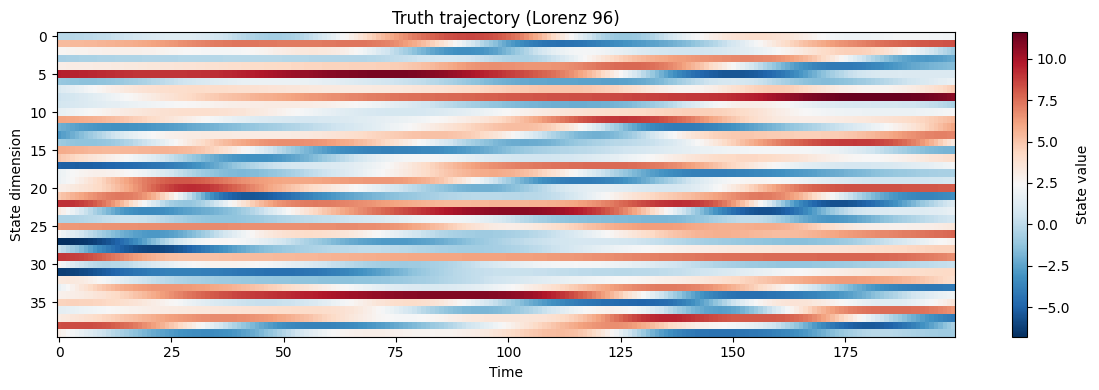

In [4]:
# Initialize truth trajectory
Xt = np.zeros((dim, warm_nt + nt))
Xt[:, 0] = F * np.ones(dim)
Xt[dim//5::dim//5, 0] = F + 1  # Perturbed IC for chaotic behavior

# Convert to TensorFlow tensor for L96_RK4
print("Integrating L96 model (warm-up + simulation)...")
for t in range(warm_nt + nt - 1):
    X_tf = tf.constant(Xt[:, t:t+1], dtype=tf.float32)
    X_next = L96_RK4(X_tf, dt, F)
    Xt[:, t+1] = X_next.numpy().flatten()
    
    if (t+1) % 200 == 0:
        print(f"  Timestep {t+1}/{warm_nt + nt}")

print("Integration complete!")

# Visualize truth
plt.figure(figsize=(12, 4))
plt.imshow(Xt[:, warm_nt:], aspect='auto', cmap='RdBu_r', interpolation='nearest')
plt.colorbar(label='State value')
plt.xlabel('Time')
plt.ylabel('State dimension')
plt.title('Truth trajectory (Lorenz 96)')
plt.tight_layout()
plt.show()

## Generate Initial Ensemble

In [5]:
if gen_ens:
    # Generate initial ensemble
    ctlmean = Xt[:, warm_nt] + np.random.multivariate_normal(np.zeros(dim), np.eye(dim))
    
    X = np.zeros((dim, np_particles, nt))
    X[:, :, 0] = np.random.multivariate_normal(ctlmean, Q, np_particles).T
    
    print(f"Initial ensemble generated with {np_particles} particles")
    print(f"Initial ensemble mean: {np.mean(X[:, :, 0], axis=1)[:5]}... (first 5 dims)")
    print(f"Initial ensemble std: {np.std(X[:, :, 0], axis=1)[:5]}... (first 5 dims)")

Initial ensemble generated with 30 particles
Initial ensemble mean: [ 1.57650501  6.63759168  2.43327139 -1.62893015  3.70589483]... (first 5 dims)
Initial ensemble std: [1.54361692 1.16663106 1.24889362 1.40751653 1.36091904]... (first 5 dims)


## Run Ensemble Without DA (Free Run)

In [6]:
if noDA_run:
    print("Running ensemble without DA (free run)...")
    XnoDA = np.zeros((dim, np_particles, nt))
    XnoDA[:, :, 0] = X[:, :, 0].copy()
    
    for t in range(nt - 1):
        X_tf = tf.constant(XnoDA[:, :, t], dtype=tf.float32)
        X_next = L96_RK4(X_tf, dt, F)
        XnoDA[:, :, t+1] = X_next.numpy()
        
        if (t+1) % 50 == 0:
            print(f"  Timestep {t+1}/{nt}")
    
    print("Free run complete!")
    
    # Save to CSV
    pd.DataFrame(XnoDA[:, :, 0]).to_csv('output.csv', index=False, header=False)
    print("Initial state saved to output.csv")

Running ensemble without DA (free run)...
  Timestep 50/200
  Timestep 100/200
  Timestep 150/200
Free run complete!
Initial state saved to output.csv


## Main PFF Algorithm - Data Assimilation

In [ ]:
if DA_run:
    print("\n" + "="*60)
    print("Starting Particle Flow Filter (PFF) Data Assimilation")
    print("="*60)
    
    t = t_start
    
    while t < nt - 1:
        # Determine if observation is available
        io_obs = ((t + 1) % da_intv == 0)
        io_pff = io_obs
        
        if t % 20 == 0:
            print(f"\nTimestep t={t+1}")
        
        if io_obs:
            print(f"  DA cycle at t={t+1}")
        
        # Step 1: Run the model (forecast)
        X_tf = tf.constant(X[:, :, t], dtype=tf.float32)
        X_next = L96_RK4(X_tf, dt, F)
        X[:, :, t+1] = X_next.numpy()
        
        # Step 2: Generate observation
        if io_obs:
            obs_time = (t + 1) // da_intv
            for i in range(ny_obs):
                inner_ind = inner_domain[i]
                obs[i, obs_time] = H_linear(Xt[inner_ind, warm_nt + t + 1]) + obs_rnd[i, obs_time]
        
        # Step 3: Particle Flow Filter - Pure TensorFlow
        if io_pff:
            # Calculate prior covariance (TensorFlow)
            X_tmp = X[:, :, t+1]
            X_tmp_tf = tf.constant(X_tmp, dtype=tf.float64)
            X_mean_tf = tf.reduce_mean(X_tmp_tf, axis=1, keepdims=True)
            X_mean_rep_tf = tf.tile(X_mean_tf, [1, np_particles])
            C_tf = inflation_fac * tf.matmul(X_tmp_tf - X_mean_rep_tf, X_tmp_tf - X_mean_rep_tf, transpose_b=True) / (np_particles - 1) / np_particles
            
            # Localization for C (TensorFlow)
            if io_local:
                # Build localization mask in TensorFlow
                mask_tf = tf.eye(dim, dtype=tf.float64)
                for i in range(1, 3 * r_influ + 1):
                    diag_val = tf.exp(tf.constant(-i**2 / r_influ**2, dtype=tf.float64))
                    # Upper diagonal
                    upper_diag = tf.linalg.diag(tf.ones(dim - i, dtype=tf.float64), k=i)
                    # Lower diagonal
                    lower_diag = tf.linalg.diag(tf.ones(dim - i, dtype=tf.float64), k=-i)
                    # Wrap-around diagonals
                    wrap_upper = tf.linalg.diag(tf.ones(i, dtype=tf.float64), k=-(dim - i))
                    wrap_lower = tf.linalg.diag(tf.ones(i, dtype=tf.float64), k=dim - i)
                    
                    mask_tf = mask_tf + diag_val * (upper_diag + lower_diag + wrap_upper + wrap_lower)
                
                C_tf = C_tf * mask_tf
            
            # All matrix operations in TensorFlow
            C_inv_tf = tf.linalg.inv(C_tf)
            B_tf = C_tf * np_particles
            B_inv_tf = C_inv_tf / np_particles
            
            # Preconditioner matrix
            qn_tf = B_tf / inflation_fac

            
            # Initialize PFF iteration (TensorFlow)
            s = 0
            ct = 0
            norm_grad_KL[obs_time, 0] = 1e8
            eps = eps_init * tf.ones(max_pseudo_step, dtype=tf.float64)
            
            pseudo_X = tf.identity(X_tmp_tf)
            
            # Observation and R in TensorFlow
            obs_current_tf = tf.constant(obs[:, obs_time:obs_time+1], dtype=tf.float64)
            R_tf = tf.constant(R, dtype=tf.float64)
            
            # Main PFF iteration loop
            while s < max_pseudo_step - 1:
                if s > 0 and norm_grad_KL[obs_time, s-1] <= stop_cri:
                    break
                
                # Evaluate observation operator (identity for observed indices)
                Hx_list = []
                for i in range(ny_obs):
                    inner_ind = inner_domain[i][0]
                    Hx_list.append(pseudo_X[inner_ind:inner_ind+1, :])
                Hx_tf = tf.concat(Hx_list, axis=0)
                
                # Calculate gradient of log posterior
                p_bkg_tf = -tf.matmul(B_inv_tf, pseudo_X - X_mean_rep_tf)
                
                # Observation term
                innovation = obs_current_tf - Hx_tf
                R_inv_innov = tf.linalg.solve(R_tf, innovation)
                
                # H^T @ R^{-1} @ innovation (H is selection matrix)
                p_obs_list = []
                for d in range(dim):
                    # Check if this dimension is observed
                    is_observed = False
                    obs_idx = -1
                    for i in range(ny_obs):
                        if inner_domain[i][0] == d:
                            is_observed = True
                            obs_idx = i
                            break
                    
                    if is_observed:
                        p_obs_list.append(R_inv_innov[obs_idx:obs_idx+1, :])
                    else:
                        p_obs_list.append(tf.zeros((1, np_particles), dtype=tf.float64))
                
                p_obs_tf = tf.concat(p_obs_list, axis=0)
                tmp_grad_log_post = p_obs_tf + p_bkg_tf
                
                # Calculate particle flow (grad_KL) - all in TensorFlow
                grad_KL_list = []
                for d in range(dim):
                    pseudo_X_d = pseudo_X[d:d+1, :]
                    diff_matrix = pseudo_X_d - tf.transpose(pseudo_X_d)
                    
                    # Kernel
                    tmp_K = tf.exp(-0.5 * diff_matrix**2 / (B_tf[d, d] * alpha))
                    tmp_grad_K = -tmp_K / (B_tf[d, d] * alpha) * (-diff_matrix)
                    
                    grad_KL_d = (tf.reduce_sum(tmp_K * tmp_grad_log_post[d:d+1, :], axis=1, keepdims=True) + 
                                 tf.reduce_sum(tmp_grad_K, axis=1, keepdims=True)) / np_particles
                    grad_KL_list.append(tf.transpose(grad_KL_d))
                
                grad_KL_tf = tf.concat(grad_KL_list, axis=0)
                
                norm_grad_KL[obs_time, s] = tf.sqrt(tf.reduce_sum(grad_KL_tf**2) / (dim * np_particles)).numpy()
                
                if s % 10 == 0:
                    print(f"    Iteration s={s}, norm={norm_grad_KL[obs_time, s]/norm_grad_KL[obs_time, 0]*100:.2f}%, eps={eps[s].numpy():.2e}")
                
                # Adaptive learning rate and update
                if s == 0:
                    stop_cri = stop_cri_percentage * norm_grad_KL[obs_time, 0]
                    pseudo_X = pseudo_X + eps[s] * tf.matmul(qn_tf, grad_KL_tf)
                    s += 1
                    ct += 1
                elif eps[s].numpy() < min_learning_rate:
                    print("    [Note] Learning rate too small, break!")
                    break
                elif s >= 1 and norm_grad_KL[obs_time, s] > 1.02 * norm_grad_KL[obs_time, s-1]:
                    new_eps = eps[s] / 1.5
                    indices = tf.range(s-1, max_pseudo_step)
                    updates = tf.fill([max_pseudo_step - s + 1], new_eps)
                    eps = tf.tensor_scatter_nd_update(eps, tf.reshape(indices, [-1, 1]), updates)
                    s -= 1
                    ct = 0
                    if s % 10 == 0:
                        print(f"    [Note] eps changed to {eps[s].numpy():.2e}, redo iteration")
                elif ct >= 7 and norm_grad_KL[obs_time, s] <= 1.02 * norm_grad_KL[obs_time, s-1]:
                    new_eps = eps[s] * 1.5
                    indices = tf.range(s, max_pseudo_step)
                    updates = tf.fill([max_pseudo_step - s], new_eps)
                    eps = tf.tensor_scatter_nd_update(eps, tf.reshape(indices, [-1, 1]), updates)
                    pseudo_X = pseudo_X + eps[s] * tf.matmul(qn_tf, grad_KL_tf)
                    s += 1
                    ct = 0
                else:
                    pseudo_X = pseudo_X + eps[s] * tf.matmul(qn_tf, grad_KL_tf)
                    s += 1
                    ct += 1
            
            s_end = s
            prior[:, :, obs_time] = X[:, :, t+1]
            X[:, :, t+1] = pseudo_X.numpy()
            
            print(f"  PFF completed in {s_end} iterations")
        
        t += 1
    
    print("\n" + "="*60)
    print("PFF Data Assimilation Complete!")
    print("="*60)


Starting Particle Flow Filter (PFF) Data Assimilation

Timestep t=1
  DA cycle at t=4
    Iteration s=0, norm=100.00%, eps=5.00e-02


/var/folders/fr/7vt2v5bs1f37tzqpnrrq0l880000gn/T/ipykernel_24123/287246177.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  obs[i, obs_time] = H_linear(Xt[inner_ind, warm_nt + t + 1]) + obs_rnd[i, obs_time]


    Iteration s=10, norm=24.03%, eps=7.50e-02
    Iteration s=20, norm=15.41%, eps=2.22e-02
    [Note] eps changed to 6.58e-03, redo iteration
    Iteration s=20, norm=15.78%, eps=6.58e-03
    Iteration s=30, norm=16.45%, eps=9.88e-03
    Iteration s=40, norm=13.45%, eps=1.48e-02
    Iteration s=50, norm=10.32%, eps=2.22e-02
    Iteration s=60, norm=8.79%, eps=6.58e-03
    [Note] eps changed to 4.39e-03, redo iteration
    Iteration s=60, norm=9.22%, eps=4.39e-03
    Iteration s=60, norm=9.26%, eps=2.57e-04
    Iteration s=70, norm=9.35%, eps=3.85e-04
    Iteration s=80, norm=9.50%, eps=5.78e-04
    Iteration s=90, norm=9.76%, eps=8.67e-04
    Iteration s=100, norm=10.26%, eps=1.95e-03
    Iteration s=110, norm=11.30%, eps=2.93e-03
    [Note] eps changed to 3.85e-04, redo iteration
    Iteration s=110, norm=12.33%, eps=3.85e-04
    [Note] eps changed to 6.68e-06, redo iteration
    Iteration s=100, norm=12.33%, eps=6.68e-06
    [Note] Learning rate too small, break!
  PFF completed in 

## Results Analysis and Visualization


RMSE Statistics:
  DA run - Mean RMSE: 0.5057
  No-DA run - Mean RMSE: 2.7990
  Improvement: 81.93%


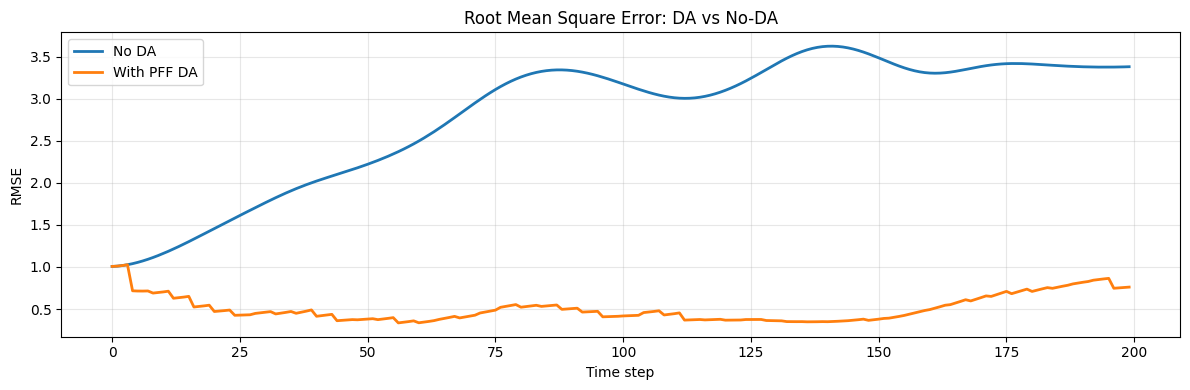

/var/folders/fr/7vt2v5bs1f37tzqpnrrq0l880000gn/T/ipykernel_22253/3283224533.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


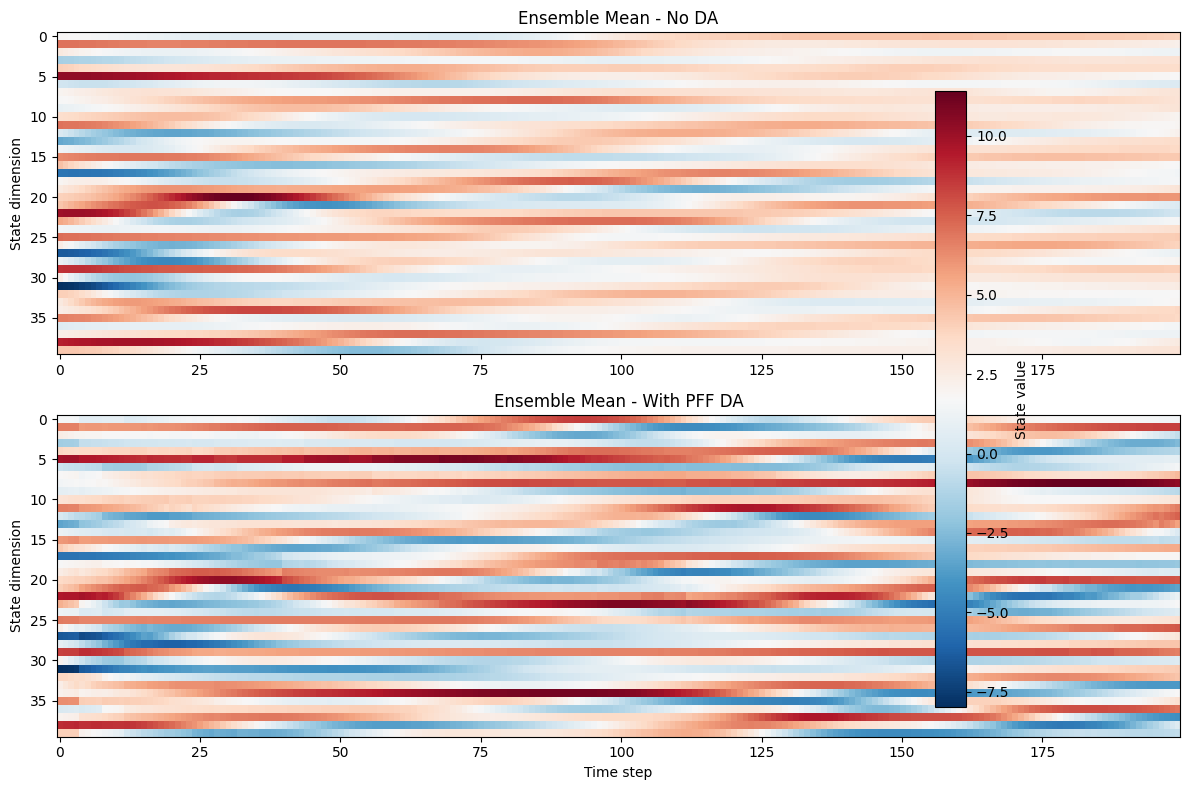

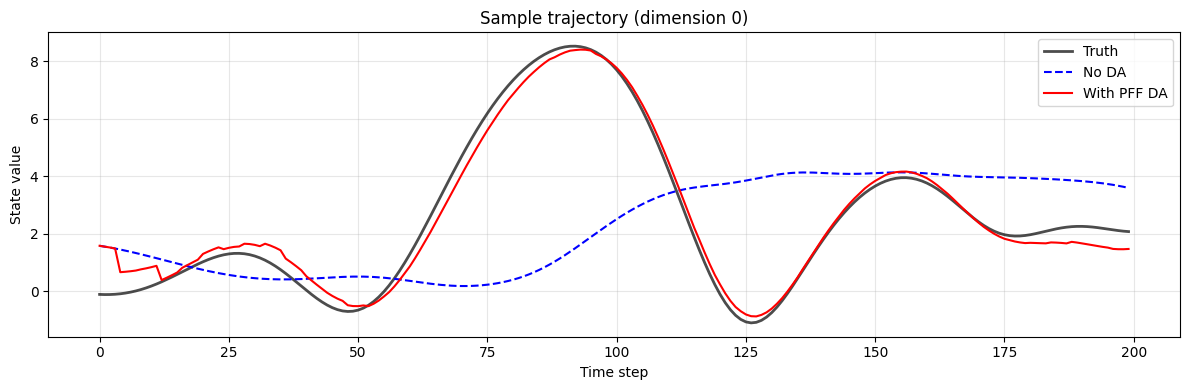

In [ ]:
# Calculate RMSE for both DA and no-DA runs
if DA_run and noDA_run:
    truth = Xt[:, warm_nt:warm_nt+nt]
    
    # Ensemble mean
    X_mean_DA = np.mean(X, axis=1)
    X_mean_noDA = np.mean(XnoDA, axis=1)
    
    # RMSE over time
    rmse_DA = np.sqrt(np.mean((X_mean_DA - truth)**2, axis=0))
    rmse_noDA = np.sqrt(np.mean((X_mean_noDA - truth)**2, axis=0))
    
    print(f"\nRMSE Statistics:")
    print(f"  DA run - Mean RMSE: {np.mean(rmse_DA):.4f}")
    print(f"  No-DA run - Mean RMSE: {np.mean(rmse_noDA):.4f}")
    print(f"  Improvement: {(1 - np.mean(rmse_DA)/np.mean(rmse_noDA))*100:.2f}%")
    
    # Plot RMSE comparison
    plt.figure(figsize=(12, 4))
    plt.plot(rmse_noDA, label='No DA', linewidth=2)
    plt.plot(rmse_DA, label='With PFF DA', linewidth=2)
    plt.xlabel('Time step')
    plt.ylabel('RMSE')
    plt.title('Root Mean Square Error: DA vs No-DA')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot ensemble spread
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    # No-DA run
    axes[0].imshow(X_mean_noDA, aspect='auto', cmap='RdBu_r', interpolation='nearest')
    axes[0].set_title('Ensemble Mean - No DA')
    axes[0].set_ylabel('State dimension')
    
    # DA run
    im = axes[1].imshow(X_mean_DA, aspect='auto', cmap='RdBu_r', interpolation='nearest')
    axes[1].set_title('Ensemble Mean - With PFF DA')
    axes[1].set_xlabel('Time step')
    axes[1].set_ylabel('State dimension')
    
    plt.colorbar(im, ax=axes, label='State value')
    plt.tight_layout()
    plt.show()
    
    # Plot sample trajectory
    sample_dim = 0
    plt.figure(figsize=(12, 4))
    plt.plot(truth[sample_dim, :], 'k-', linewidth=2, label='Truth', alpha=0.7)
    plt.plot(X_mean_noDA[sample_dim, :], 'b--', linewidth=1.5, label='No DA')
    plt.plot(X_mean_DA[sample_dim, :], 'r-', linewidth=1.5, label='With PFF DA')
    plt.xlabel('Time step')
    plt.ylabel('State value')
    plt.title(f'Sample trajectory (dimension {sample_dim})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## PFF Convergence Analysis

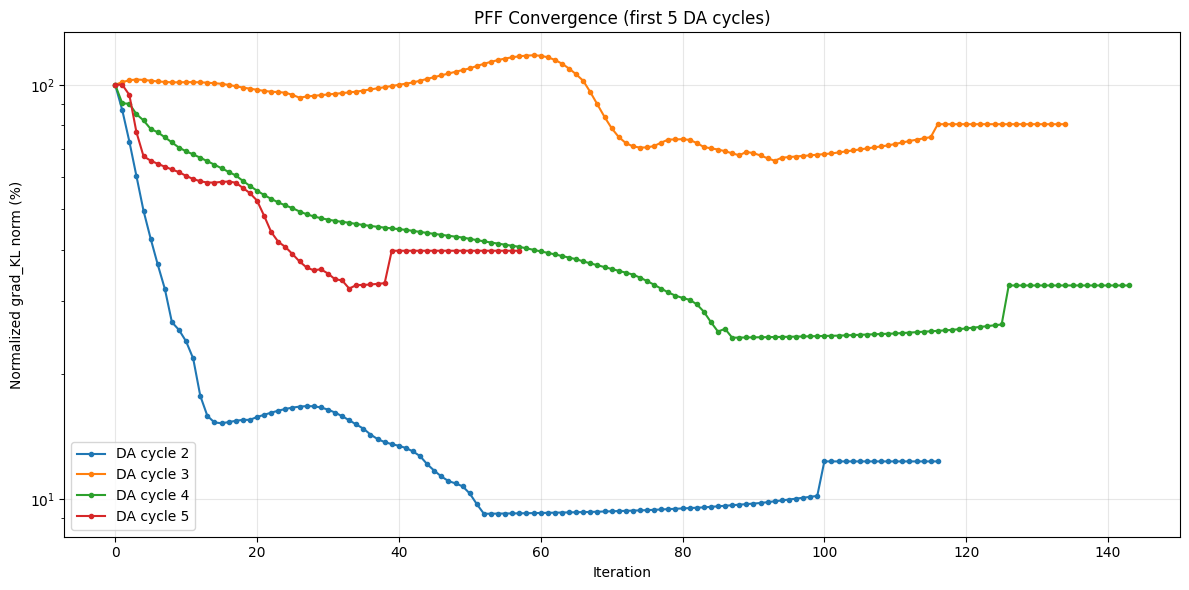


PFF Iteration Statistics:
  Mean iterations per DA cycle: 118.8
  Min iterations: 31
  Max iterations: 149


In [ ]:
if DA_run:
    # Plot convergence of gradient norm
    plt.figure(figsize=(12, 6))
    
    for obs_time in range(min(5, total_obs)):  # Plot first 5 DA cycles
        valid_idx = norm_grad_KL[obs_time, :] > 0
        if np.any(valid_idx):
            iterations = np.arange(max_pseudo_step)[valid_idx]
            norms = norm_grad_KL[obs_time, valid_idx]
            plt.semilogy(iterations, norms / norms[0] * 100, 
                        marker='o', markersize=3, label=f'DA cycle {obs_time+1}')
    
    plt.xlabel('Iteration')
    plt.ylabel('Normalized grad_KL norm (%)')
    plt.title('PFF Convergence (first 5 DA cycles)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    iterations_per_cycle = []
    for obs_time in range(total_obs):
        valid_idx = norm_grad_KL[obs_time, :] > 0
        if np.any(valid_idx):
            iterations_per_cycle.append(np.sum(valid_idx))
    
    if iterations_per_cycle:
        print(f"\nPFF Iteration Statistics:")
        print(f"  Mean iterations per DA cycle: {np.mean(iterations_per_cycle):.1f}")
        print(f"  Min iterations: {np.min(iterations_per_cycle)}")
        print(f"  Max iterations: {np.max(iterations_per_cycle)}")

In [ ]:
print("\n" + "="*60)
print("Particle Flow Filter Demo Complete!")
print("="*60)


Particle Flow Filter Demo Complete!
